In [145]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap, ListedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from fiona import Env
import geopandas as gpd
from shapely.geometry import mapping
from rasterio import mask as msk

# Data Preprocessing


## Population Density Data


In order to build our genetic slime mold algorithm, we need a pretri dish with with sustenance allowing the mold to feed, multiply, adapt and grow. To do so, we are going to use the GHS-POP dataset from GHSL - Global Human Settlement Layer

https://ghsl.jrc.ec.europa.eu/download.php?ds=pop

This dataset contains global demographic information. To model a network of train stations and rails, we chose to use population density as our vector.

The 1km resolution was initially selected in fear of long processing times but was later switched to 100m to improve the heat map's resolution


#### CONST AND FILE PATH


In [276]:
population_data_file = "pop_density2.tif"
shapefile_path = "tl_2022_us_county/tl_2022_us_county.shp"
CRS = "ESRI:54009"

Null values are represnted by -200. For the sake of simplicity and for a clearer visualization, we are setting these values to 0.


In [165]:
tif_file = rasterio.open(population_data_file)
ghs_data = tif_file.read()
ghs_data[0][ghs_data[0] < 0.0] = 0.0

The CRS of this data is ESRI:54009: a geographic coordinate reference system (CRS) used to represent coordinates on the global level.

This ended up being very troublesome when trying to overlay and trim our "county" data with our pop density data. We were unaware that these two files used a different CRS and ran into a plethora of bugs when figuring this out.

In the output below, we can see that our bounds correspond to a square with a rectified min value of 0 and a max of 1334, corresponding to the population density per $100m^2$


/var/folders/cm/zcxw77hs2_7gcc5rgzmbmv9w0000gn/T/ipykernel_24846/3027813748.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ourcmap = cm.get_cmap('hot_r', 460)


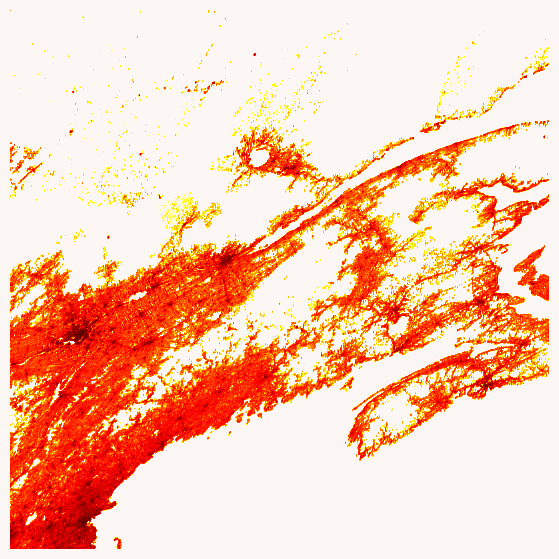

In [280]:
ourcmap = cm.get_cmap("hot_r", 460)
newcolors = ourcmap(np.linspace(0, 1, 460))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors[:1, :] = background_colour
newcmp = ListedColormap(newcolors)
fig, ax = plt.subplots(facecolor="#FCF6F5FF")
fig.set_size_inches(14, 7)
ax.imshow(ghs_data[0], norm=colors.LogNorm(), cmap=newcmp)
ax.axis("off")
plt.show()


The graph above shows a heatmap of the selected population density data.

Boston, our target location, can be seen in the bottom left of the heatmap.


### Suffolk County

In order to hone in on Boston, I was able to find a shape file containing a geometric and global representation of Suffolk County.

https://www.suffolkcountyny.gov/services/GIS

Thanks to GeoPandas to_crs method, we were able to reproject a GeoDataFrame to a new coordinate reference system (CRS).


In [179]:
counties = gpd.read_file(shapefile_path)
suffolk_county = counties[(counties["STATEFP"] == "25") & (counties["NAME"] == "Suffolk")]  # .to_crs(tif_file.crs)

suffolk_county = suffolk_county.to_crs(CRS)

In [278]:
print("Tiff Boundary", tif_file.bounds)
print("Tiff CRS", tif_file.crs)
print("Data shape", ghs_data.shape)
print("Max value", np.amax(ghs_data))
print("Min value", np.amin(ghs_data))

print("Raster CRS:", tif_file.crs)
print("Raster bounds:", tif_file.bounds)
print("Shapefile CRS:", suffolk_county.crs)
print("Shapefile bounds:", suffolk_county.total_bounds)


Tiff Boundary BoundingBox(left=-6041000.0, bottom=5000000.0, right=-5041000.0, top=6000000.0)
Tiff CRS ESRI:54009
Data shape (1, 10000, 10000)
Max value 1334.266357421875
Min value 0.0
Raster CRS: ESRI:54009
Raster bounds: BoundingBox(left=-6041000.0, bottom=5000000.0, right=-5041000.0, top=6000000.0)
Shapefile CRS: ESRI:54009
Shapefile bounds: [-5915728.91910055  5036871.99465816 -5863391.54196737  5061380.03573755]


After reprojecting the contents of our .sh file, we can now see that the bounds of our suffolk county geometry are withn the bounds of our population density data and that the Shapefile CRS is equal to that of our .tiff file

We can see this overlap in the graph below


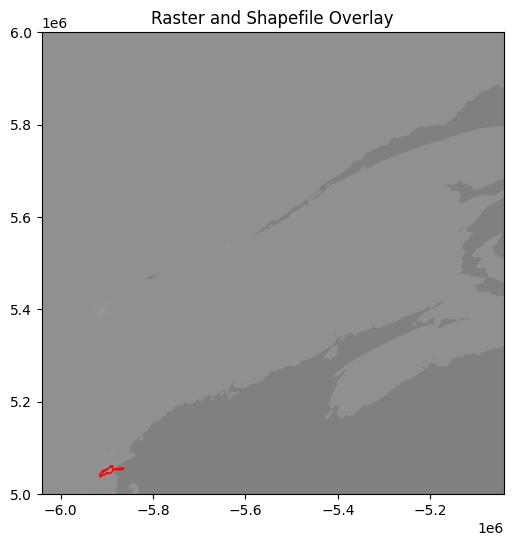

In [181]:
import matplotlib.pyplot as plt

raster_data = tif_file.read(1)
raster_extent = rasterio.plot.plotting_extent(tif_file)
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(raster_data, extent=raster_extent, cmap="gray", alpha=0.5)
suffolk_county.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Raster and Shapefile Overlay")
plt.show()


msk.mask is a function in the Rasterio library that masks a dataset using a GeoJSON-like geometry.

The function takes several input parameters including:

- dataset: our .tiff,
- [shapes]: our .sh,
- crop: a boolean indicating whether to crop the output to the extent of the mask


In [281]:
# Gets the geometry from the GeoDataFrame as a list of shapely geometries
suffolk_county_geometry = [geom for geom in suffolk_county.geometry]

# Uses the list of geometries when masking the raster
suff_array, clipped_trasform = msk.mask(tif_file, suffolk_county_geometry, crop=True)

Now that we have extracted our target geometry from the dataset, we can plot a heatmap of the shape which now includes the population density data


/var/folders/cm/zcxw77hs2_7gcc5rgzmbmv9w0000gn/T/ipykernel_24846/1130607203.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  our_cmap = cm.get_cmap("hot_r", 10)


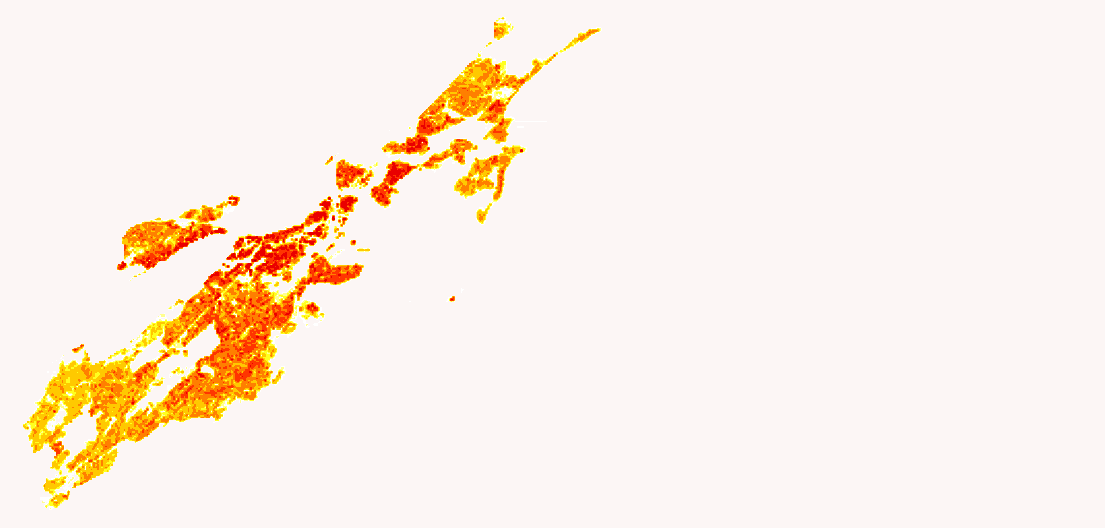

In [183]:
our_cmap = cm.get_cmap("hot_r", 10)
newcolors = our_cmap(np.linspace(0, 1, 10))
background_colour = np.array([0.9882352941176471, 0.9647058823529412, 0.9607843137254902, 1.0])
newcolors = np.vstack((background_colour, newcolors))
our_cmap = ListedColormap(newcolors)
bounds = [0.0, 1, 5, 10, 20, 50, 100, 200, 1000, 2000, 10000]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

fig, ax = plt.subplots(facecolor="#FCF6F5FF")
fig.set_size_inches(14, 7)
ax.imshow(suff_array[0], norm=norm, cmap=our_cmap)
ax.axis("off")
plt.show()


The heatmap above displays the population density of suffolk county with a 100m resolution


# Genetic Algorithm: Most Efficient Station Distribution


The k-means clustering and slime mold genetic algorithm approach is a method for finding optimal paths through a spatial domain based on the natural behavior of slime molds. This approach combines the power of k-means clustering and genetic algorithms to efficiently navigate through areas with varying population densities.


## K-Mean Clustering


In this approach, we start by utilizing the k-means clustering algorithm to group the spatial data points into k clusters, where each cluster represents a region with similar characteristics, such as population density or terrain type. The cluster centers provide an indication of the high-density areas in the domain, which can be considered as important waypoints or hubs for navigation.


In [171]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np


In [172]:
def create_clusters(raster_data, k):
    y, x = np.where(raster_data > 0)
    population = raster_data[y, x]

    data = np.column_stack((x, y, population))

    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data)

    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(standardized_data)

    cluster_centroids = scaler.inverse_transform(kmeans.cluster_centers_)

    x_coords = cluster_centroids[:, 0]
    y_coords = cluster_centroids[:, 1]
    population_values = cluster_centroids[:, 2]

    return x_coords, y_coords, population_values

/Users/adamazoulay/Desktop/ai_proj/env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


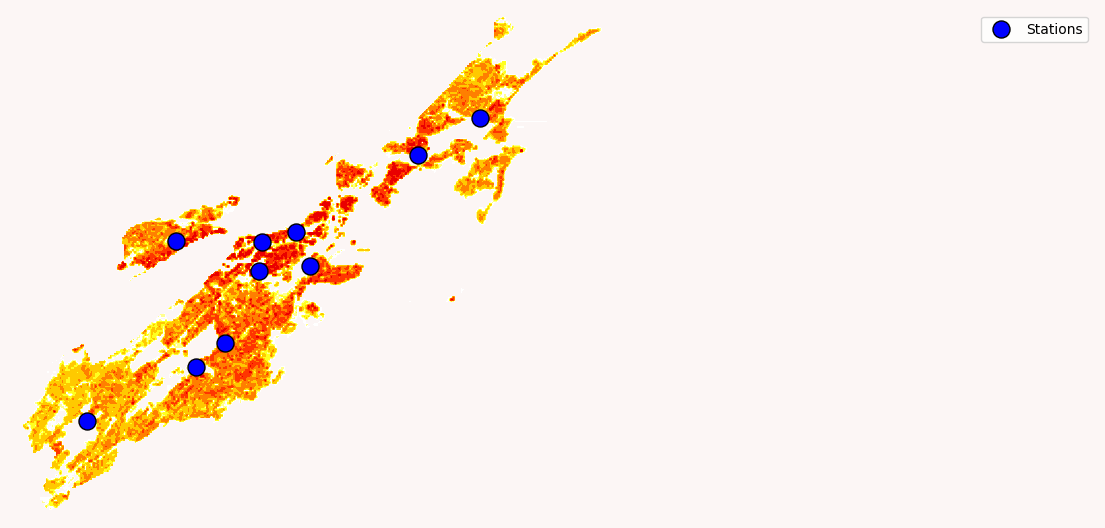

In [324]:
k = 10  # Number of clusters

x_coords, y_coords, population_values = create_clusters(suff_array[0], k)
fig, ax = plt.subplots(facecolor="#FCF6F5FF")
fig.set_size_inches(14, 7)
ax.imshow(suff_array[0], norm=norm, cmap=our_cmap)
ax.scatter(x_coords, y_coords, c="blue", marker="o", edgecolor="black", s=150, label="Stations")
ax.axis("off")
plt.legend()
plt.show()
# print(x_coords, y_coords, population_values)

The graph above shows the result of running the clustering algorithm with k=10 clusters. As you can see, these are distributed to allow collection of nodes to access most of the suffolk county population. These nodes are more densely packed in higher population density areas


## Genetic Algorithm


We model the slime mold's behavior using a genetic algorithm. The slime mold is known for its ability to find the shortest path between two points while avoiding obstacles and efficiently exploring the environment. The genetic algorithm mimics this behavior by evolving a population of candidate paths over several generations, with each path representing a potential route between the starting point and the destination.


In [330]:
import numpy as np
import random
from itertools import combinations
from collections import defaultdict


### Helper Functions


The slime mold genetic algorithm employs several helper methods to implement the core genetic algorithm components. These methods are responsible for creating the initial population, evaluating fitness, selecting individuals for reproduction, performing crossover, and applying mutation.

- <b> create_initial_population </b>: Initializes a population of chromosomes (variants), where each chromosome represents a potential path. It takes the population size, nodes (stations), and maximum connections as input parameters. It creates a random set of connections between the nodes, up to a threshhold.

- <b> fitness </b>: Calculates the fitness of a chromosome (path) based on its efficiency. It takes a chromosome, the options array, and the x and y coordinates of the nodes as input parameters. The efficiency is computed as the sum of the squared product of population densities of the connected nodes. Higher efficiency indicates a better path.

- <b> roulette_wheel_selection </b>: Responsible for selecting chromosomes for reproduction based on their fitness values. It implements the roulette wheel selection algorithm, where chromosomes with higher fitness values have a higher probability of being selected. It takes the population and their corresponding fitness values as input parameters.

- <b> crossover </b>: Performs the crossover operation between two parent chromosomes, creating two offspring chromosomes. It uses a two-point crossover, which means it selects two random crossover points in the parent chromosomes and exchanges the segments between them to generate the offspring. If the parents have only one connection, a single-point crossover is applied. This method takes two parent chromosomes as input parameters.

- <b> mutate </b>: Applies mutation to a chromosome with a given mutation rate. If a random value is less than the mutation rate, the method will decide whether to add or remove a connection based on a 50% chance. If the method decides to remove a connection, it will randomly remove one connection from the chromosome. If it decides to add a connection, it will create a new connection between two random nodes and add it to the chromosome, provided the new connection is not already present. This method takes a chromosome, mutation rate, and nodes as input parameters.

These helper methods work together to evolve the population of chromosomes over several generations, eventually finding an optimal path that resembles the behavior of a slime mold. The combination of k-means clustering and the slime mold genetic algorithm allows for efficient pathfinding while considering important waypoints and avoiding obstacles or low-density areas.


In [331]:
def create_initial_population(population_size, nodes, max_connections):
    population = []
    for _ in range(population_size):
        num_connections = random.randint(1, max_connections)
        connections = random.sample(list(combinations(nodes, 2)), num_connections)
        population.append(connections)
    return population


def fitness(chromosome, suff_array, x_coords, y_coords):
    efficiency = 0
    for edge in chromosome:
        point1, point2 = edge
        x1, y1 = int(x_coords[point1]), int(y_coords[point1])
        x2, y2 = int(x_coords[point2]), int(y_coords[point2])
        pop_density1 = suff_array[0, y1, x1]
        pop_density2 = suff_array[0, y2, x2]
        efficiency += (pop_density1 + pop_density2) * (pop_density1 + pop_density2)
    return efficiency


def roulette_wheel_selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    selection_probs = [fitness / total_fitness for fitness in fitnesses]
    return np.random.choice(population, size=len(population), replace=True, p=selection_probs)


def crossover(parent1, parent2):
    if len(parent1) > 1 and len(parent2) > 1:
        crossover_points = sorted(random.sample(range(1, len(parent1)), min(2, len(parent1) - 1)))
        if len(crossover_points) == 1:
            offspring1 = parent1[: crossover_points[0]] + parent2[crossover_points[0] :]
            offspring2 = parent2[: crossover_points[0]] + parent1[crossover_points[0] :]
        else:
            offspring1 = parent1[: crossover_points[0]] + parent2[crossover_points[0] : crossover_points[1]] + parent1[crossover_points[1] :]
            offspring2 = parent2[: crossover_points[0]] + parent1[crossover_points[0] : crossover_points[1]] + parent2[crossover_points[1] :]
    else:
        offspring1, offspring2 = parent1, parent2
    return offspring1, offspring2


def mutate(chromosome, mutation_rate, nodes):
    if random.random() < mutation_rate:
        if random.random() < 0.5 and len(chromosome) > 1:
            chromosome.pop(random.randint(0, len(chromosome) - 1))
        else:
            new_connection = random.sample(nodes, 2)
            if new_connection not in chromosome:
                chromosome.append(new_connection)
    return chromosome


### Genetic Algorithm


In [332]:
# Genetic Algorithm
def slime_mold_genetic_algorithm(suff_array, x_coords, y_coords, num_generations, population_size, max_connections, mutation_rate):
    nodes = list(range(len(x_coords)))
    population = create_initial_population(population_size, nodes, max_connections)

    for generation in range(num_generations):
        fitnesses = [fitness(chromosome, suff_array, x_coords, y_coords) for chromosome in population]
        selected_population = roulette_wheel_selection(population, fitnesses)

        new_population = []
        for i in range(0, population_size, 2):
            offspring1, offspring2 = crossover(selected_population[i], selected_population[i + 1])
            offspring1 = mutate(offspring1, mutation_rate, nodes)
            offspring2 = mutate(offspring2, mutation_rate, nodes)
            new_population.extend([offspring1, offspring2])

        population = new_population

    best_chromosome = max(population, key=lambda x: fitness(x, suff_array, x_coords, y_coords))
    return best_chromosome

In [24]:
num_generations = 10000
population_size = 250
max_connections = 7  # Could be improved to deterministically find balance between num of connections and complexity
mutation_rate = 0.5


/var/folders/cm/zcxw77hs2_7gcc5rgzmbmv9w0000gn/T/ipykernel_34601/3637945049.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.random.choice(population, size=len(population), replace=True, p=selection_probs)


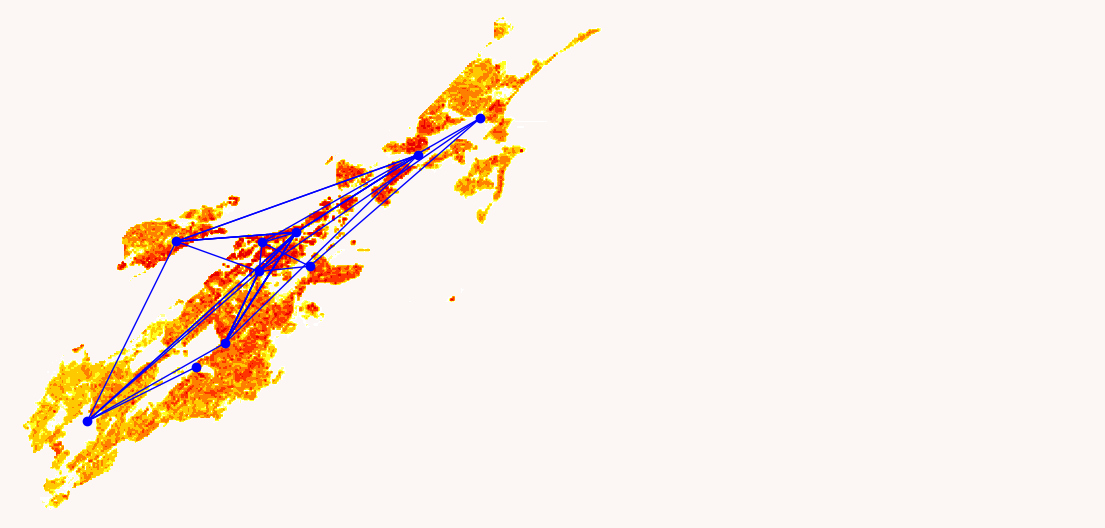

In [26]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

best_chromosome = slime_mold_genetic_algorithm(suff_array, x_coords, y_coords, num_generations, population_size, max_connections, mutation_rate)

lines = [[(x_coords[edge[0]], y_coords[edge[0]]), (x_coords[edge[1]], y_coords[edge[1]])] for edge in best_chromosome]
lc = LineCollection(lines, linewidths=1, color="blue")

fig, ax = plt.subplots(facecolor="#FCF6F5FF")
fig.set_size_inches(14, 7)
ax.imshow(suff_array[0], norm=norm, cmap=our_cmap)
ax.scatter(x_coords, y_coords, color="blue", zorder=2)
ax.add_collection(lc)
ax.axis("off")
plt.show()

The grapha above displays the result of running our K-clustring algorithm and the edges generated by our genetic algorithm.

We can see that the genetic algorithm geenrates an efficient arrangement of nodes to connect the nodes of the graph

These results can vary drastically based on different input parameters.

The graph above was generated using the following configuration:

- num_generations = 10000
- population_size = 250
- max_connections = 7
- mutation_rate = 0.5


## What I Learned and Next Steps


Throughout this project, we have gained valuable experience in data processing and working with geospatial data using libraries like geopandas and rasterio. We faced challenges in reading and manipulating geospatial data files, extracting relevant information, and transforming the data into suitable formats for our algorithm. Tackling these data preprocessing obstacles proved crucial in incorporating real-world data into our genetic algorithm, which in turn, enhanced its practical applicability.

The current algorithm focuses on population density as the primary factor for optimizing the network. However, there is potential to improve it by considering additional aspects of a city, such as the locations of schools, offices, hospitals, and other essential facilities. Taking into account geologic factors, such as areas unsuitable for digging due to soil composition, water bodies, or the presence of pre-existing critical infrastructure, can also play a significant role in refining the algorithm. These factors can help generate more realistic and practical network designs, taking into account the limitations posed by the urban environment.

Furthermore, integrating transportation infrastructure data, such as the proximity of existing roads or public transit networks, can improve the algorithm's relevance in real-world applications. By considering traffic patterns, local regulations, and environmental factors like terrain or climate, we can create a more comprehensive and efficient network design that caters to a broader range of needs.

For this genetic algorithm to act more like slime mold, an A* traversal algorithm that explores the graph may be more appropriate. However, since the resolution of the map was increased significantly to focus on a smaller area, the processing time required was too high. Additionally, since the graph is disconnected, which can be seen in various sections of the heatmap, an A* algorithm would not have been possible without increasing the complexity of the algorithm significantly or further processing the data to remove or bridge disjoint sets of points.

In summary, this project has provided valuable insights into data processing, geospatial analysis, and the potential for improvement and innovation in network design optimization. By incorporating additional factors like geologic constraints and pre-existing infrastructure, the algorithm can be further refined to address the complex challenges of urban planning and development more effectively.
